In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matching_evaluation as me 
from linear_prog_LEM_optimiser import linear_programming_matcher, prepare_data
import time

In [3]:
bid_df = pd.read_csv('./data/bids.csv', index_col=0)
df = bid_df.merge(pd.read_csv('./data/assets.csv', index_col=0), on='asset',).sort_values(['time','bid'])
df.head()

,bid,asset,time,volume_kwh,price_gbp_kwh,carbon_gco2_kwh,type,size_kw
0,b0000,a0124,0,-371,>1.43,22,generator,2040
162,b0001,a0504,0,-439,>3.63,7,generator,1920
328,b0002,a1434,0,808,<2.12,NaN,consumer,8280
516,b0003,a2839,0,1840,<3.45,NaN,consumer,6860
683,b0004,a0335,0,-611,>0.04,11,generator,7100


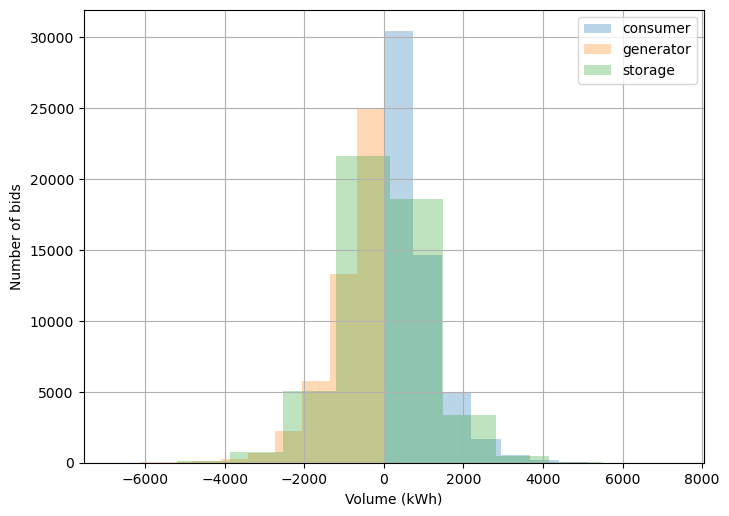

In [4]:
plt.figure(figsize=(8,6),dpi=100)
for name, group in df.groupby('type'):
    group.volume_kwh.hist(alpha = 0.3, label=name)
plt.xlabel('Volume (kWh)')
plt.ylabel('Number of bids')
plt.legend()
plt.show()

In [5]:
# All bid sizes are within limits
(df.volume_kwh <= df.size_kw).value_counts(), (abs(df.volume_kwh) < df.size_kw).value_counts()

(True    149804
 dtype: int64,
 True    149804
 dtype: int64)

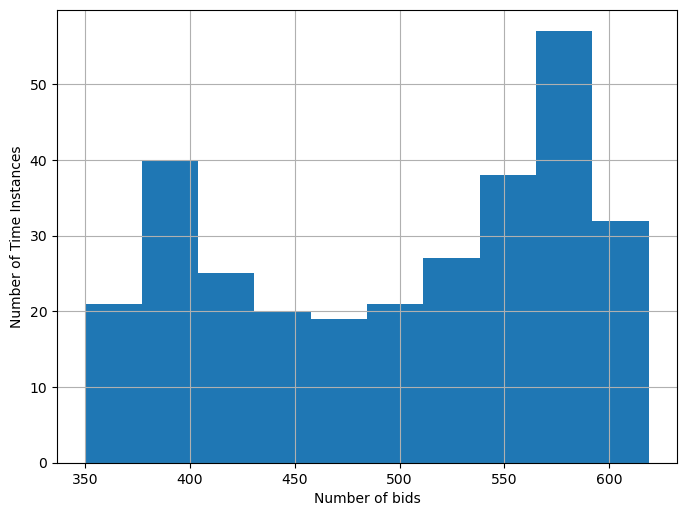

In [6]:
plt.figure(figsize=(8,6),dpi=100)
df.time.value_counts().hist()
plt.xlabel('Number of bids')
plt.ylabel('Number of Time Instances')
plt.show()

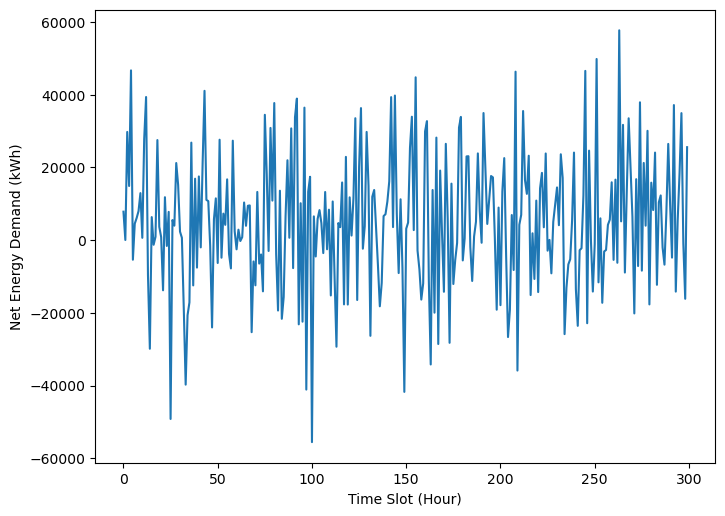

In [7]:
plt.figure(figsize=(8,6),dpi=100)
df.groupby('time').volume_kwh.sum().plot()
plt.xlabel('Time Slot (Hour)')
plt.ylabel('Net Energy Demand (kWh)')
plt.show()
# Negative means higher suply, positive means higher demand

In [8]:
df[df.price_gbp_kwh.str[0] == '=']
# all price_gbp_kwh signs that = '=' are invalid purchases

,bid,asset,time,volume_kwh,price_gbp_kwh,carbon_gco2_kwh,type,size_kw
14798,b0088,a0108,0,0,=4.82,NaN,consumer,120
7225,b6870,a1986,13,0,=5.47,NaN,consumer,100
82479,b10778,a1597,19,0,=2.89,<27,storage,140
81654,b23120,a2775,40,0,=1.1,NaN,storage,80
26046,b27398,a1223,48,0,=2.57,9,generator,60
7283,b54168,a1986,110,0,=1.41,NaN,consumer,100
14873,b54205,a0108,110,0,=3.64,NaN,consumer,120
40532,b62450,a1061,128,0,=3.69,<29,storage,180
131629,b75877,a2801,152,0,=2.55,15,generator,160
81729,b88967,a2775,174,0,=3.23,NaN,storage,80


In [9]:
df[df.carbon_gco2_kwh.str[0] == '='] # no exact carbon demands exist

,bid,asset,time,volume_kwh,price_gbp_kwh,carbon_gco2_kwh,type,size_kw


In [10]:
seller_df, buyer_df = prepare_data(df)

In [11]:
seller_df.price_gbp_kwh_sign.value_counts()

>    68703
<     3616
Name: price_gbp_kwh_sign, dtype: int64

In [12]:
buyer_df.price_gbp_kwh_sign.value_counts()

<    73639
>     3832
Name: price_gbp_kwh_sign, dtype: int64

In [13]:
buyer_df.carbon_gco2_kwh_sign.value_counts() # > includes previous nans

>    54945
<    22526
Name: carbon_gco2_kwh_sign, dtype: int64

In [14]:
power_evaluation = []
cash_evaluation = []
user_evaluation = []
power_evaluation_scaled = []
time_evaluation = []
for i in df.time.unique():
    working_df = df.query(f'`time` == {i}')
    t0 = time.time()
    transactions = linear_programming_matcher(working_df)
    t1 = time.time()
    time_evaluation += [t1 - t0]
    power_evaluation += [me.evaluate_solution_power(transactions, working_df)]
    power_evaluation_scaled += [me.evaluate_solution_power_relative(transactions, working_df)]
    cash_evaluation += [me.evaluate_solution_cashflow(transactions)]
    user_evaluation += [me.evaluate_solution_bidder_penetration(transactions, working_df)]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/bc/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/aa1d7fc5239a42b7950e69217eb4f4e0-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/aa1d7fc5239a42b7950e69217eb4f4e0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 593 COLUMNS
At line 99383 RHS
At line 99972 BOUNDS
At line 129555 ENDATA
Problem MODEL has 588 rows, 29582 columns and 69207 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 521 (-67) rows, 29456 (-126) columns and 61685 (-7522) elements
Perturbing problem by 0.001% of 2612.0428 - largest nonzero change 0.0085175372 ( 0.0026829353%) - largest zero change 0
0  Obj 0 Dual inf 26736850 (29456)
85  Obj -7728126.3 Primal inf 47353.346 (461)
170  Obj -3453377.1 Primal inf 21719.791 (394)
255  Obj -1202699.5 Primal inf 7278.9099 (308)
340  Obj -528601.57 Prim

In [15]:
np.mean(time_evaluation), np.std(time_evaluation)

(2.690857572555542, 0.9122562935285201)

In [16]:
np.mean(power_evaluation), np.std(power_evaluation)

(12446.994746666665, 11025.057482417527)

In [17]:
np.mean(power_evaluation_scaled), np.std(power_evaluation_scaled)

(0.03178000365829918, 0.027845774582216484)

In [18]:
np.mean(cash_evaluation), np.std(cash_evaluation)

(1142.7645333333332, 208.0837338575881)

In [19]:
np.mean(user_evaluation), np.std(user_evaluation)

(0.9548419452095875, 0.024182329026569586)

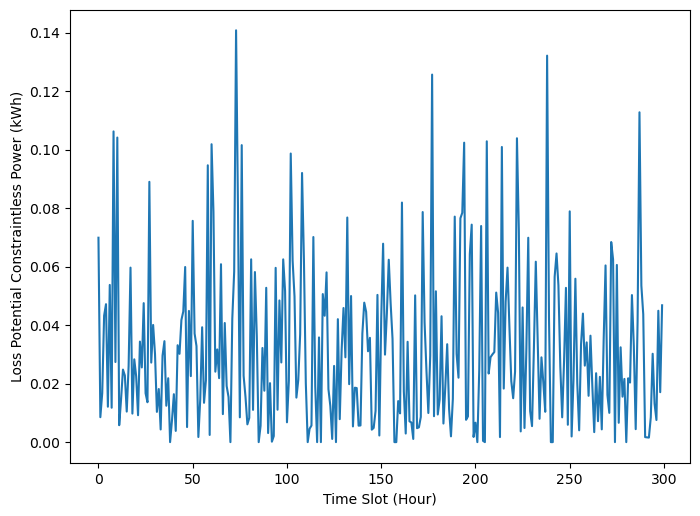

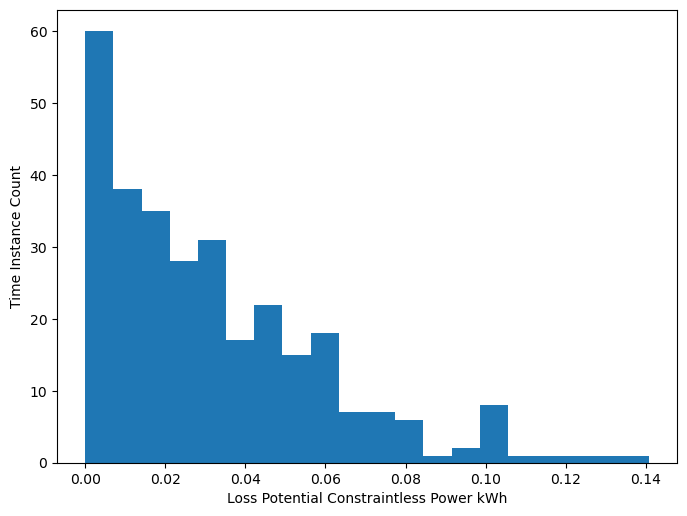

In [20]:
me.plot_power_evaluation(power_evaluation_scaled) # technically wrong labels as relative

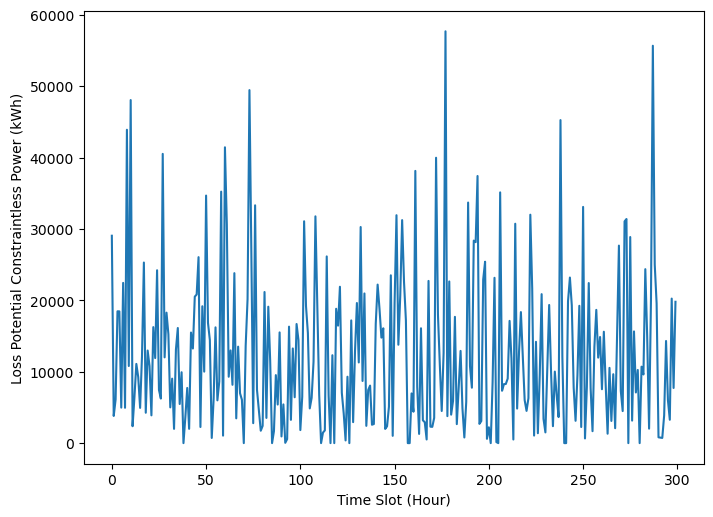

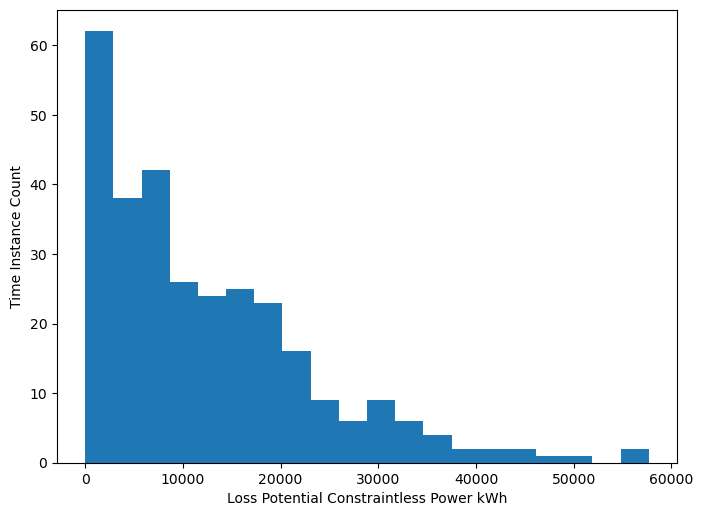

In [21]:
me.plot_power_evaluation(power_evaluation)

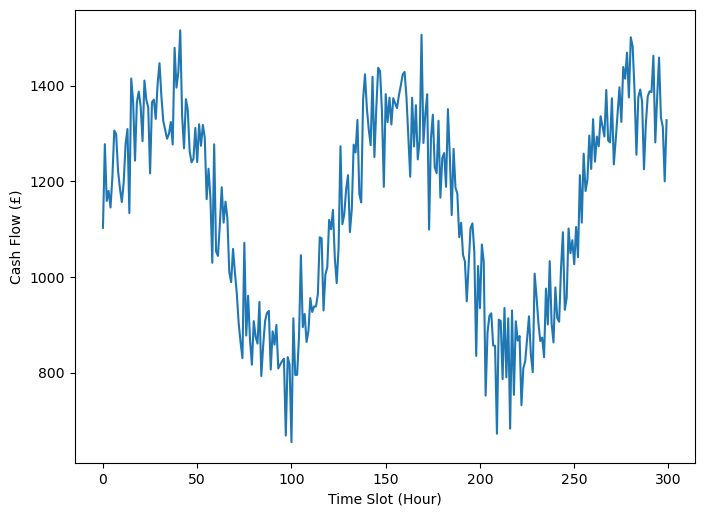

In [22]:
me.plot_cash_evaluation(cash_evaluation)

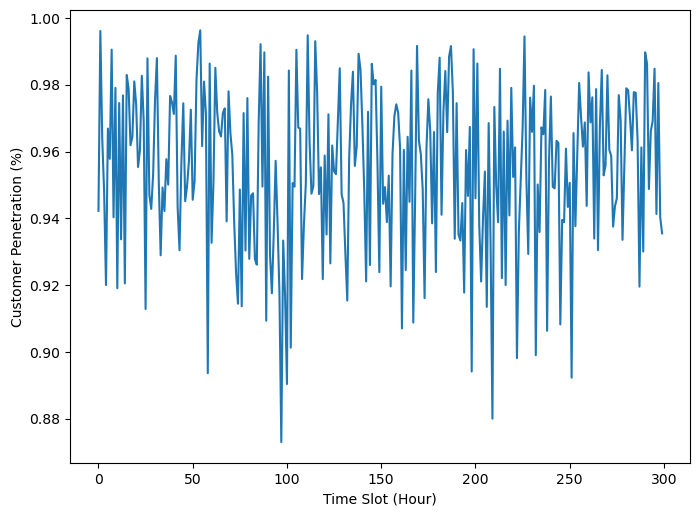

In [23]:
me.plot_user_evaluation(user_evaluation)